# YanoljaNEXT-Rosetta-12B Ollama 테스트
## MES 질문/프롬프트 한국어 ↔ 영어 번역

### 특징
- **AsyncClient 사용** - 비동기 처리
- **스트리밍** - 실시간 응답 수신
- **done 플래그 감지** - 모델 완료 신호 확인
- **JSON 3단계 파싱** - 다양한 응답 형식 대응

## 1. 라이브러리 임포트

In [1]:
from ollama import AsyncClient
import asyncio
import time
import json
import re
from typing import Dict
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("✓ Libraries loaded")

✓ Libraries loaded


## 2. Ollama 설정

In [11]:
# ⚠️ 여기를 실제 환경에 맞게 수정하세요
OLLAMA_HOST = "http://192.168.1.70:11434"
MODEL_NAME = "hf.co/mradermacher/YanoljaNEXT-Rosetta-12B-2510-i1-GGUF:Q4_K_M"

# import ollama
# client = ollama.Client(host=OLLAMA_HOST)
# models = client.list()
# for model in models:
#     print(f"{model}\n")

print(f"Ollama Host: {OLLAMA_HOST}")
print(f"Model: {MODEL_NAME}")

Ollama Host: http://192.168.1.70:11434
Model: hf.co/mradermacher/YanoljaNEXT-Rosetta-12B-2510-i1-GGUF:Q4_K_M


## 3. 비동기 번역 함수

In [ ]:
async def translate_with_ollama(source: Dict, target_language: str, context: Dict = None) -> Dict:
    """
    Ollama AsyncClient를 사용한 JSON 번역
    
    Args:
        source: 번역할 JSON 데이터
        target_language: 타겟 언어 (English, Korean 등)
        context: 번역 컨텍스트 (tone, context 등)
    
    Returns:
        Dict: 번역 결과 및 성능 메트릭
    """
    
    # 시스템 프롬프트 구성
    system_parts = [f"Translate the user's text to {target_language}."]
    
    if context:
        for key, value in context.items():
            key_pascal = key.capitalize()
            if isinstance(value, dict):
                system_parts.append(f"{key_pascal}:")
                for f, t in value.items():
                    system_parts.append(f"- {f} -> {t}")
            else:
                system_parts.append(f"{key_pascal}: {value}")
    
    system_parts.append("Provide the final translation immediately without any other text.")
    
    system_message = "\n".join(system_parts)
    user_message = json.dumps(source, ensure_ascii=False)

    mem_before = psutil.Process().memory_info().rss / 1024**2
    start_time = time.time()
    
    try:
        # AsyncClient 생성
        client = AsyncClient(host=OLLAMA_HOST)
        
        # 비동기 스트리밍 chat
        response_stream = await client.chat(
            model=MODEL_NAME,
            messages=[
                {'role': 'system', 'content': system_message},
                {'role': 'user', 'content': user_message}
            ],
            stream=True,
        )
        
        # 스트림에서 응답 수집
        full_response = ""
        eval_count = 0
        
        async for chunk in response_stream:
            content = chunk['message']['content']
            full_response += content
            
            # 통계 업데이트
            if 'eval_count' in chunk:
                eval_count = chunk.get('eval_count', 0)
            
            # done 플래그로 완료 감지
            if chunk.get('done', False):
                break
        
        inference_time = time.time() - start_time
        tokens_per_second = eval_count / inference_time if inference_time > 0 else 0
        
    except Exception as e:
        return {
            "error": str(e),
            "translation": None,
            "inference_time": 0,
            "tokens_generated": 0,
            "tokens_per_second": 0,
            "memory_used": 0
        }
    
    # JSON 파싱 (3단계)
    try:
        # 1. 전체 응답을 JSON으로 파싱
        translation = json.loads(full_response.strip())
    except (json.JSONDecodeError, IndexError) as e:
        translation = {"raw_response": full_response, "error": str(e)}
    
    mem_after = psutil.Process().memory_info().rss / 1024**2
    
    return {
        "translation": translation,
        "translation_text": full_response,
        "inference_time": inference_time,
        "tokens_generated": eval_count,
        "tokens_per_second": tokens_per_second,
        "memory_used": mem_after - mem_before,
    }

print("✓ Async translation function defined")

✓ Async translation function defined


## 4. 테스트 데이터

In [53]:
test_data = [
    {
        "category": "terminology",
        "target_language": "English",
        "context": {"context": "MES", "tone": "Professional"},
        "source": {"work_order": "작업 지시서", "production_plan": "생산 계획"},
        "reference": {"work_order": "Work Order", "production_plan": "Production Plan"}
    },
    {
        "category": "simple_question",
        "target_language": "English",
        "context": {"context": "Production", "tone": "Natural"},
        "source": {"question": "오늘 생산 라인의 가동률이 어떻게 되나요?"},
        "reference": {"question": "What is today's production line utilization rate?"}
    },
    {
        "category": "complex_question",
        "target_language": "English",
        "context": {"context": "Analysis", "tone": "Technical"},
        "source": {"request": "계획일자가 2024년 10월 23일 23시 11분 23초 이후이고, 생산일자가 '2025-01-01 12:34:56' 이후인 작업지시 목록을 조회해주세요. 작업지시 키, 작업지시 번호, 지시 유형, 지시상태, 품목 키, 품목 코드, 품목 명, 품목 유형, 지시 수량, 라우팅 키, 라우팅 코드, 라우팅 명, 계획 시작일자, 계획 종료일자, 생산 시작일자, 생산 종료일자, 비고, 지시 유형명, 지시 상태명의 형태로 조회해주세요."},
        "reference": {"request": "Compare Line 2's production and defect rate from yesterday."}
    },
    {
        "category": "simple_question",
        "target_language": "Korean",
        "context": {"context": "Work order", "tone": "Natural"},
        "source": {"question": "What is the status of work order WO-2025-001?"},
        "reference": {"question": "작업 지시서 WO-2025-001의 상태는 어떻게 되나요?"}
    },
]

print(f"Test samples: {len(test_data)}")
print(f"  → English: {sum(1 for d in test_data if d['target_language'] == 'English')}")
print(f"  → Korean: {sum(1 for d in test_data if d['target_language'] == 'Korean')}")

Test samples: 4
  → English: 3
  → Korean: 1


## 5. 단일 테스트

In [54]:
# 첫 번째 샘플 테스트
sample = test_data[0]

print(f"Category: {sample['category']}")
print(f"Target: {sample['target_language']}")
print(f"\nSource:")
print(json.dumps(sample['source'], indent=2, ensure_ascii=False))

# 비동기 함수 실행
result = await translate_with_ollama(
    sample['source'], 
    sample['target_language'],
    context=sample.get('context')
)

if result.get('error'):
    print(f"\n❌ Error: {result['error']}")
else:
    print(f"\nTranslation:")
    print(json.dumps(result['translation'], indent=2, ensure_ascii=False))
    print(f"\nReference:")
    print(json.dumps(sample['reference'], indent=2, ensure_ascii=False))
    print(f"\n⏱️  {result['inference_time']:.2f}s | 🚀 {result['tokens_per_second']:.1f} tok/s")

Category: terminology
Target: English

Source:
{
  "work_order": "작업 지시서",
  "production_plan": "생산 계획"
}

Translation:
{
  "work_order": "Work Order",
  "production_plan": "Production Plan"
}

Reference:
{
  "work_order": "Work Order",
  "production_plan": "Production Plan"
}

⏱️  2.29s | 🚀 8.3 tok/s


## 6. 전체 테스트

In [55]:
# 비동기로 모든 샘플 테스트
async def run_all_tests():
    results = []
    
    for idx, sample in enumerate(test_data, 1):
        print(f"\n[{idx}/{len(test_data)}] {sample['category']} → {sample['target_language']}")
        
        result = await translate_with_ollama(
            sample['source'],
            sample['target_language'],
            context=sample.get('context')
        )
        
        if result.get('error'):
            print(f"❌ {result['error']}")
            continue
        
        print(f"⏱️  {result['inference_time']:.2f}s | 🚀 {result['tokens_per_second']:.1f} tok/s")
        
        results.append({
            'id': idx,
            'category': sample['category'],
            'target_language': sample['target_language'],
            'source': json.dumps(sample['source'], ensure_ascii=False),
            'translation': json.dumps(result['translation'], ensure_ascii=False),
            'reference': json.dumps(sample['reference'], ensure_ascii=False),
            'inference_time': result['inference_time'],
            'tokens_generated': result['tokens_generated'],
            'tokens_per_second': result['tokens_per_second'],
            'memory_used': result['memory_used']
        })
    
    return results

# 실행
results = await run_all_tests()
print(f"\n✓ Completed: {len(results)}/{len(test_data)}")


[1/4] terminology → English
⏱️  0.31s | 🚀 60.8 tok/s

[2/4] simple_question → English
⏱️  0.29s | 🚀 58.7 tok/s

[3/4] complex_question → English
⏱️  1.77s | 🚀 78.7 tok/s

[4/4] simple_question → Korean
⏱️  0.48s | 🚀 60.3 tok/s

✓ Completed: 4/4


## 7. 결과 분석

In [50]:
if len(results) > 0:
    df = pd.DataFrame(results)
    
    print(f"\n{'='*80}")
    print(f"Performance Summary")
    print(f"{'='*80}")
    print(f"\nSamples: {len(df)}")
    print(f"\nInference Time:")
    print(f"  Mean: {df['inference_time'].mean():.3f}s")
    print(f"  Min:  {df['inference_time'].min():.3f}s")
    print(f"  Max:  {df['inference_time'].max():.3f}s")
    print(f"\nSpeed:")
    print(f"  Mean: {df['tokens_per_second'].mean():.1f} tok/s")
    print(f"  Min:  {df['tokens_per_second'].min():.1f} tok/s")
    print(f"  Max:  {df['tokens_per_second'].max():.1f} tok/s")
    
    print(f"\nBy Category:")
    for cat in df['category'].unique():
        cat_df = df[df['category'] == cat]
        print(f"  {cat}: {cat_df['inference_time'].mean():.3f}s")
    
    display(df[['id', 'category', 'target_language', 'inference_time', 'tokens_per_second']])
else:
    print("❌ No results")


Performance Summary

Samples: 4

Inference Time:
  Mean: 0.408s
  Min:  0.351s
  Max:  0.493s

Speed:
  Mean: 51.7 tok/s
  Min:  47.5 tok/s
  Max:  56.8 tok/s

By Category:
  terminology: 0.400s
  simple_question: 0.422s
  complex_question: 0.389s


,id,category,target_language,inference_time,tokens_per_second
0,1,terminology,English,0.399776,47.526617
1,2,simple_question,English,0.351346,48.385383
2,3,complex_question,English,0.388559,54.045832
3,4,simple_question,Korean,0.492820,56.815873


## 8. 시각화

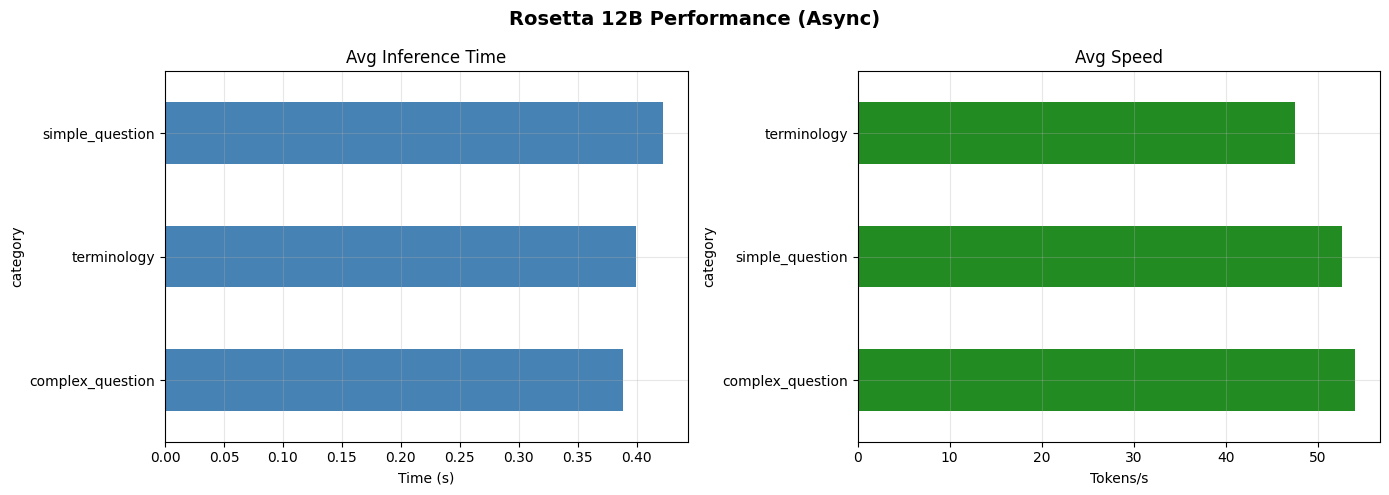

In [51]:
if len(results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Rosetta 12B Performance (Async)', fontsize=14, fontweight='bold')
    
    # 카테고리별 시간
    df.groupby('category')['inference_time'].mean().sort_values().plot(
        kind='barh', ax=axes[0], color='steelblue'
    )
    axes[0].set_xlabel('Time (s)')
    axes[0].set_title('Avg Inference Time')
    axes[0].grid(True, alpha=0.3)
    
    # 카테고리별 속도
    df.groupby('category')['tokens_per_second'].mean().sort_values(ascending=False).plot(
        kind='barh', ax=axes[1], color='forestgreen'
    )
    axes[1].set_xlabel('Tokens/s')
    axes[1].set_title('Avg Speed')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. 결과 저장

In [ ]:
if len(results) > 0:
    # CSV 저장
    df.to_csv('rosetta_12b_async_results.csv', index=False, encoding='utf-8-sig')
    
    # JSON 요약
    summary = {
        'host': OLLAMA_HOST,
        'model': MODEL_NAME,
        'mode': 'async',
        'samples': len(df),
        'avg_time': float(df['inference_time'].mean()),
        'avg_speed': float(df['tokens_per_second'].mean()),
        'categories': {}
    }
    
    for cat in df['category'].unique():
        cat_df = df[df['category'] == cat]
        summary['categories'][cat] = {
            'count': len(cat_df),
            'avg_time': float(cat_df['inference_time'].mean()),
            'avg_speed': float(cat_df['tokens_per_second'].mean())
        }
    
    with open('rosetta_12b_async_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print("✓ Results saved:")
    print("  - rosetta_12b_async_results.csv")
    print("  - rosetta_12b_async_summary.json")

## 10. 커스텀 테스트

In [56]:
# 직접 입력하여 테스트
custom_source = {
    "question": "'PD202509010017' 작업지시의 일별 생산실적 수량을 알려주세요."
}
custom_context = {
    "context": "MES",
    "tone": "Naturel",
    "glossary": {
        "작업지시": "Production Order",
    }
}

print("Custom Test:")
print(json.dumps(custom_source, indent=2, ensure_ascii=False))

result = await translate_with_ollama(custom_source, "English", context=custom_context)

if not result.get('error'):
    print("\nTranslation:")
    print(json.dumps(result['translation'], indent=2, ensure_ascii=False))
    print(f"\n⏱️  {result['inference_time']:.2f}s | 🚀 {result['tokens_per_second']:.1f} tok/s")
else:
    print(f"\n❌ {result['error']}")

Custom Test:
{
  "question": "'PD202509010017' 작업지시의 일별 생산실적 수량을 알려주세요."
}

Translation:
{
  "question": "Please provide the daily production quantity for Production Order 'PD202509010017'."
}

⏱️  0.47s | 🚀 64.2 tok/s
